**Kidney Stone Classication using CT_Images**  

**Importing and Installing required libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
!unzip /content/CT_images.zip

Archive:  /content/CT_images.zip
   creating: CT_images/
   creating: CT_images/Test/
   creating: CT_images/Test/Normal/
  inflating: CT_images/Test/Normal/Normal- (1001).jpg  
  inflating: CT_images/Test/Normal/Normal- (1002).jpg  
  inflating: CT_images/Test/Normal/Normal- (1003).jpg  
  inflating: CT_images/Test/Normal/Normal- (1004).jpg  
  inflating: CT_images/Test/Normal/Normal- (1005).jpg  
  inflating: CT_images/Test/Normal/Normal- (1006).jpg  
  inflating: CT_images/Test/Normal/Normal- (1007).jpg  
  inflating: CT_images/Test/Normal/Normal- (1008).jpg  
  inflating: CT_images/Test/Normal/Normal- (1009).jpg  
  inflating: CT_images/Test/Normal/Normal- (1010).jpg  
  inflating: CT_images/Test/Normal/Normal- (1011).jpg  
  inflating: CT_images/Test/Normal/Normal- (1012).jpg  
  inflating: CT_images/Test/Normal/Normal- (1013).jpg  
  inflating: CT_images/Test/Normal/Normal- (1014).jpg  
  inflating: CT_images/Test/Normal/Normal- (1015).jpg  
  inflating: CT_images/Test/Normal/Nor

**Preparing Traning Data**  

In [ ]:
folder_path = "/content/CT_images/Train"
filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)

    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            filenames.append(os.path.join(category, filename))
            categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,Stone/Stone- (378).jpg,Stone
1,Stone/Stone- (51).jpg,Stone
2,Stone/Stone- (316).jpg,Stone
3,Stone/Stone- (899).jpg,Stone
4,Stone/Stone- (823).jpg,Stone


In [ ]:
df.tail()

,filename,category
2995,Normal/Normal- (2044).jpg,Normal
2996,Normal/Normal- (945).jpg,Normal
2997,Normal/Normal- (787).jpg,Normal
2998,Normal/Normal- (1473).jpg,Normal
2999,Normal/Normal- (1588).jpg,Normal


<Axes: xlabel='category'>

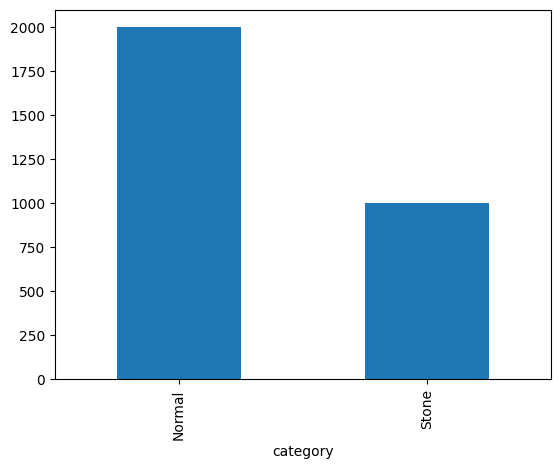

In [ ]:
df['category'].value_counts().plot.bar()

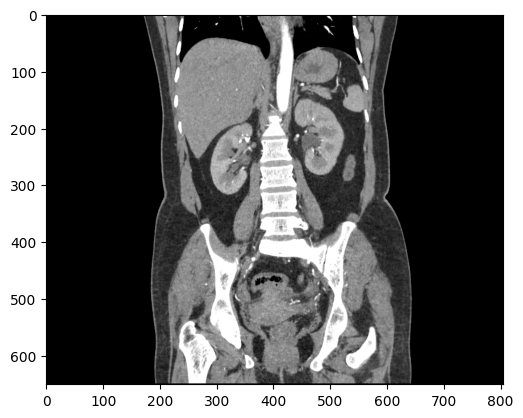

In [ ]:
sample = random.choice(filenames)
image_path = "/content/CT_images/Train/" + sample
image = load_img(image_path)
plt.imshow(image)
plt.show()

**Building CNN Model**  

In [ ]:
model = Sequential()

#Adding convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding a second convolutional layer
model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2)) # as we have binary class i.e stone and normal so value is 2
model.add(Activation('sigmoid')) #sigmoid for binary class classification

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                        

**Early Stop**  
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [ ]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**  
We will reduce the learning rate when then accuracy not increase for 2 steps

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

**Preparing Data**

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

**Train and Validation generator**  

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/CT_images/Train",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/CT_images/Train",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


**Visulaizing the output**

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/CT_images/Train",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


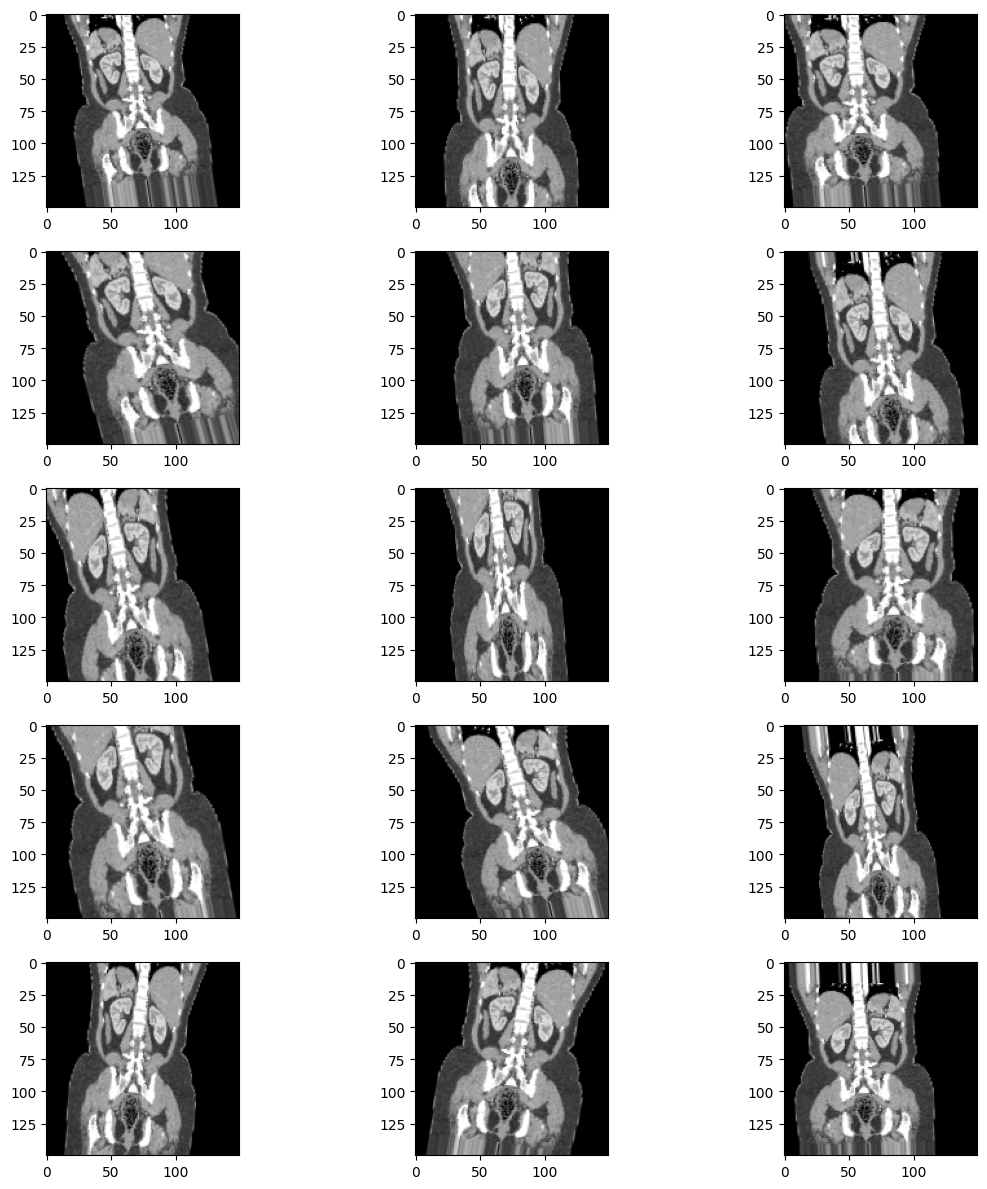

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

**Fitting the Model**

In [ ]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//15,
    steps_per_epoch=train_df.shape[0]//15,
    callbacks=callbacks
)

Epoch 1/15
160/160 [==============================] - 163s 1s/step - loss: 0.5795 - accuracy: 0.7504 - val_loss: 3.5840 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/15
160/160 [==============================] - 164s 1s/step - loss: 0.3676 - accuracy: 0.8558 - val_loss: 1.1594 - val_accuracy: 0.4117 - lr: 0.0010
Epoch 3/15
160/160 [==============================] - 161s 1s/step - loss: 0.3111 - accuracy: 0.8737 - val_loss: 0.4166 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 4/15
160/160 [==============================] - 160s 1s/step - loss: 0.2894 - accuracy: 0.8842 - val_loss: 1.1236 - val_accuracy: 0.7483 - lr: 0.0010
Epoch 5/15
160/160 [==============================] - 157s 981ms/step - loss: 0.2800 - accuracy: 0.8913 - val_loss: 0.1818 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 6/15
160/160 [==============================] - 158s 988ms/step - loss: 0.2493 - accuracy: 0.8979 - val_loss: 1.5414 - val_accuracy: 0.7533 - lr: 0.0010
Epoch 7/15
160/160 [==============================] - ETA:

**Visualizing the Training history**  

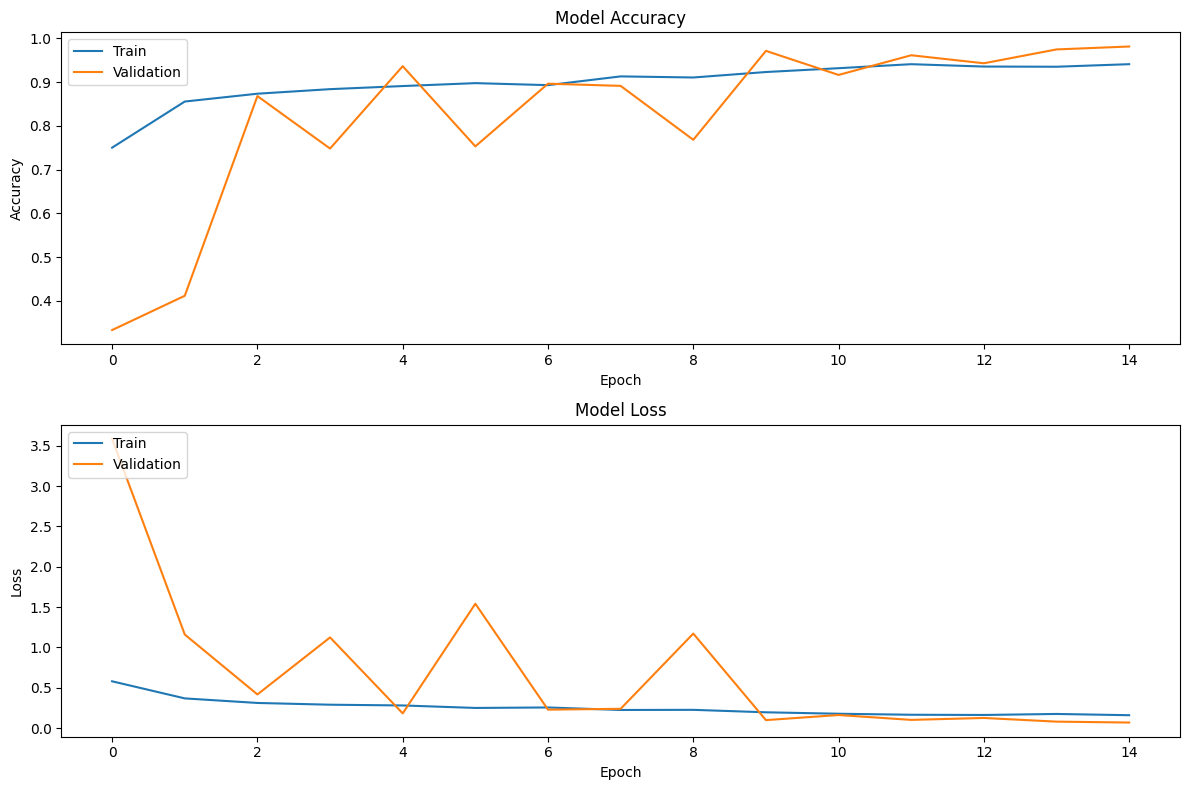

In [ ]:
# Plotting the training history
plt.figure(figsize=(12, 8))

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/My Drive/model.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Testing Data

In [ ]:
test_folder_path = "/content/CT_images/Test"
test_filenames = []
test_categories = []

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)

    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/CT_images/Test/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15,
    shuffle=False
)

Found 900 validated image filenames belonging to 2 classes.


### Predictions

In [ ]:
steps = np.ceil(test_df.shape[0] / 15)

predict = model.predict(test_generator, steps=steps)

60/60 [==============================] - 11s 183ms/step


In [ ]:
test_df['predicted category'] = np.argmax(predict, axis=-1)

In [ ]:
test_df['predicted category'] = test_df['predicted category'].replace({ 1: 'Stone', 0: 'Normal' })

In [ ]:
test_df.head()

,filename,category,predicted category
0,Stone/Stone- (1210).jpg,Stone,Normal
1,Stone/Stone- (1001).jpg,Stone,Stone
2,Stone/Stone- (1198).jpg,Stone,Normal
3,Stone/Stone- (1285).jpg,Stone,Normal
4,Stone/Stone- (1294).jpg,Stone,Normal


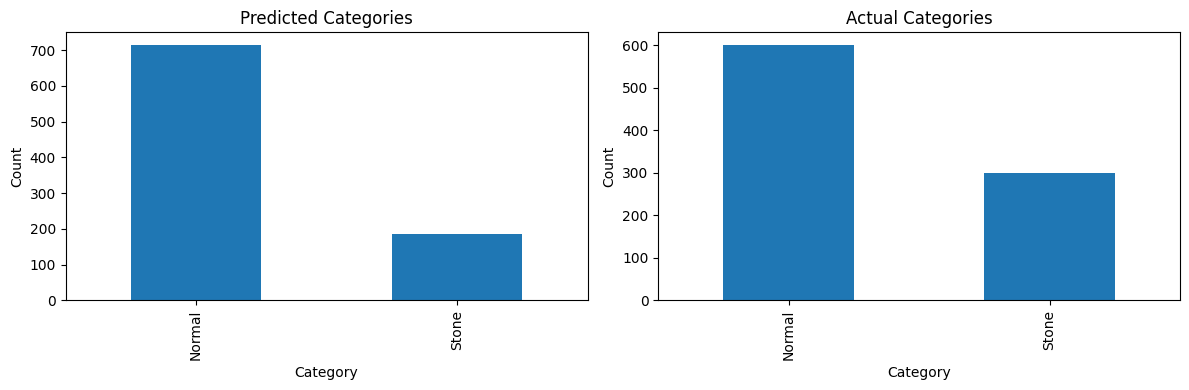

In [ ]:
plt.figure(figsize=(12, 4))

# Plot the first bar plot (predicted category)
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Plot the second bar plot (actual category)
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

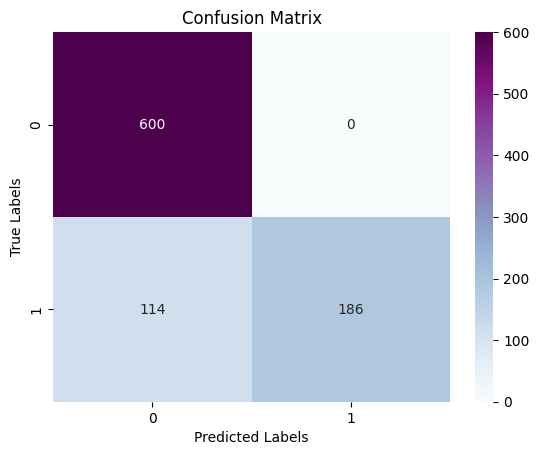

In [ ]:
cm = confusion_matrix(test_df['category'], test_df['predicted category'])

sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
model.evaluate(test_generator)

60/60 [==============================] - 11s 176ms/step - loss: 0.2503 - accuracy: 0.8733


[0.2502982020378113, 0.8733333349227905]

**GUI**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/content/drive/My Drive/model.keras')

# Verify the model structure
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                        

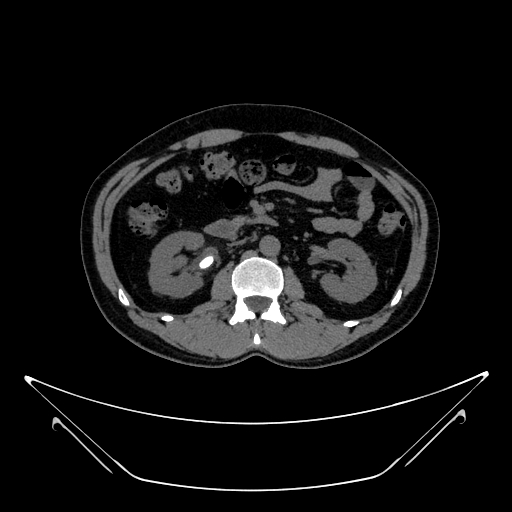

1/1 [==============================] - 0s 35ms/step
The uploaded image is classified as: **Stone**

Do you want to check another picture?


In [ ]:
import ipywidgets as widgets
from IPython.display import display as ipy_display, clear_output
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from PIL import Image

# Load the trained CNN model
model_path = '/content/drive/My Drive/model.keras'
trained_model = load_model(model_path)

# Global variables
upload_button = None  # File upload widget
yes_no_buttons = None  # Yes/No buttons for continuation

# Function to preprocess a single image
def preprocess_image(uploaded_file):
    """
    Preprocess the uploaded image to match the CNN input requirements.
    Args:
        uploaded_file: Uploaded image file from ipywidgets.
    Returns:
        Preprocessed image ready for prediction.
    """
    img = load_img(uploaded_file, target_size=(150, 150))  # Resize to 150x150
    img = img_to_array(img) / 255.0  # Convert to array and normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to display the uploaded image
def display_uploaded_image(image_name):
    """Displays the uploaded image."""
    img = Image.open(image_name)
    ipy_display(img)  # Use the aliased function for display

# Function to make predictions
def predict_image(change):
    """
    Handle image upload event and classify the image using the CNN model.
    """
    clear_output()  # Clear previous outputs
    uploaded_file = upload_button.value
    if uploaded_file:
        # Extract the first uploaded file
        file_info = list(uploaded_file.values())[0]
        image_name = file_info['metadata']['name']

        # Save the uploaded file temporarily
        with open(image_name, 'wb') as f:
            f.write(file_info['content'])

        # Display the uploaded image
        display_uploaded_image(image_name)

        # Preprocess the image and make predictions
        img = preprocess_image(image_name)
        prediction = trained_model.predict(img)
        class_name = 'Stone' if np.argmax(prediction) == 1 else 'Normal'

        # Display result
        print(f"The uploaded image is classified as: **{class_name}**")

        # Ask the user if they want to check another image
        prompt_for_next_image()

# Function to prompt Yes/No buttons
def prompt_for_next_image():
    """
    Prompt the user to check another image or exit.
    """
    global yes_no_buttons
    print("\nDo you want to check another picture?")
    yes_no_buttons = widgets.HBox([
        widgets.Button(description="Yes", button_style="success"),
        widgets.Button(description="No", button_style="danger")
    ])

    # Assign button callbacks
    yes_no_buttons.children[0].on_click(restart_upload)  # Yes button
    yes_no_buttons.children[1].on_click(exit_app)        # No button

    ipy_display(yes_no_buttons)

# Function to restart the upload process
def restart_upload(button):
    """
    Restart the upload process for a new image.
    """
    clear_output()
    print("Upload an image to check if it contains a Stone or is Normal:")
    ipy_display(upload_button)

# Function to exit the app
def exit_app(button):
    """
    End the app with a thank-you message.
    """
    clear_output()
    print("Thank you for using the image classification app! 😊")

# Widget for file upload
upload_button = widgets.FileUpload(
    accept='image/*',  # Accept only images
    multiple=False  # Single file upload
)

# Display initial prompt
print("Please upload an image to check if it contains a Stone or is Normal:")
ipy_display(upload_button)

# Observe the file upload event and trigger prediction
upload_button.observe(predict_image, names='value')
